Application of GPcounts with Negative Binomial likelihood on spatial data from Mouse olfactory bulb to identify spatially expressed genes. 

We first calculate the scale factors using negative binomial regression with identity link function using R glm package. 


R Kernel 

In [1]:
library(sva)
library(MASS)

Loading required package: mgcv

Loading required package: nlme

This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.

Loading required package: genefilter

Loading required package: BiocParallel


Attaching package: ‘MASS’


The following object is masked from ‘package:genefilter’:

    area




In [2]:
counts <- read.table(file='../data/MouseOB/Rep11_MOB_0.csv', header=TRUE, sep=',')
cells <- read.table(file='../data/MouseOB/locations.csv', header=TRUE, sep=',')

In [3]:
rownames(counts) = counts[,1]
rownames(cells) = cells[,1]
counts = counts[,-1]
cells = cells[,-1]

In [4]:
counts = cbind(counts,cells$total_counts)
colnames(counts)[14860] = 'total_counts'
coeffs_nb <-list()
scales_nb <- list()
total_counts = c(cells$total_counts)


In [5]:
for (x in c(1:100))
{
  results<-glm.nb(formula=counts[,x]~0+counts$total_counts,link=identity, data=counts)
  coeffs = as.data.frame(results$coefficients)
  scales <- results$coefficients*total_counts
  scales = as.data.frame(scales)
  scales_nb <- append(scales_nb,scales)
}

scales_nb=write.table(scales_nb,sep = "\t","../data/MouseOB/scales_nb.txt",col.names = TRUE, row.names = F)


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”


In [ ]:
Switch to Python kernel

In [1]:
import pandas as pd 
import numpy as np 
import gpflow
import tensorflow as tf
from GPcounts import NegativeBinomialLikelihood
from GPcounts.GPcounts_Module import Fit_GPcounts
from matplotlib import pyplot as plt

In [2]:
def get_coords(index):
    coords = pd.DataFrame(index=index)
    coords['x'] = index.str.split('x').str.get(0).map(float)
    coords['y'] = index.str.split('x').str.get(1).map(float)
    return coords

In [8]:
# spatial expression counts matrix
Y = pd.read_csv('../data/MouseOB/Rep11_MOB_0.csv', index_col=[0])
Y = Y.T[Y.sum(0) >= 3].T

In [9]:
sample_info = get_coords(Y.index)
sample_info['total_counts'] = Y.sum(1)
sample_info = sample_info.query('total_counts > 10')  # Remove empty features
Y = Y.loc[sample_info.index]
X = sample_info[['x', 'y']]
scale=pd.read_csv('../data/MouseOB/scales_nb.txt', sep="\t")

In [10]:
Y=Y.T
Y=Y.iloc[0:100,:] # select first 100 genes to run GPcounts
X = X[['x', 'y']]

In [11]:
gene_name = []
scaled = True # set the default scaled argument to True to consider the scale factors
gene_name = Y.index
likelihood = 'Negative_binomial' 
gp_counts = Fit_GPcounts(X,Y.loc[gene_name],scale.loc[scale.index], scaled = scaled)

In [12]:
log_likelihood_ratio = gp_counts.One_sample_test(likelihood)
print(log_likelihood_ratio)

100%|██████████| 100/100 [47:51<00:00, 28.72s/it]  

           Dynamic_model_log_likelihood  Constant_model_log_likelihood  \
Nrf1                        -254.819471                    -249.488997   
Zbtb5                       -264.393017                    -264.393018   
Ccnl1                       -470.179801                    -470.179801   
Lrrfip1                     -425.489793                    -426.373556   
Bbs1                        -399.702923                    -399.751612   
...                                 ...                            ...   
Cdk5                        -481.184725                    -481.184709   
Arf4                        -633.048654                    -633.048656   
Lrfn4                       -366.845222                    -366.845224   
Hist1h2ad                    -51.627847                     -51.653942   
Dnajc4                      -298.083621                    -298.699255   

           log_likelihood_ratio    Dynamic_time   Constant_time   p value  \
Nrf1               0.000000e+00  0

Plot some spatially expressed genes from the data set

In [30]:
df = log_likelihood_ratio.sort_values(by=['q value'])
df.head(20)

,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio,Dynamic_time,Constant_time,p value,q value
Pcp4,-1026.571837,-1103.334771,76.762934,0:03:02.318543,0:03:02.318543,0.000000e+00,0.000000e+00
Cldn5,-561.379826,-603.094561,41.714736,0:00:03.018993,0:00:03.018993,1.056100e-10,5.280498e-09
Pmepa1,-662.073182,-698.336572,36.263390,0:00:03.236498,0:00:03.236498,1.723717e-09,5.745722e-08
Eef1a1,-1090.546952,-1117.142656,26.595704,0:11:42.245484,0:11:42.245484,2.508008e-07,6.270020e-06
Sh3gl2,-787.296650,-810.821519,23.524870,0:00:02.918460,0:00:02.918460,1.233095e-06,2.466190e-05
2010300C02Rik,-660.911520,-683.227110,22.315590,0:00:03.027325,0:00:03.027325,2.313210e-06,3.855350e-05
Fyco1,-516.379348,-537.104877,20.725529,0:00:02.729868,0:00:02.729868,5.300461e-06,7.572088e-05
Fam213a,-734.582332,-747.439051,12.856718,0:00:03.015181,0:00:03.015181,3.362698e-04,4.203372e-03
Gnb2,-690.087200,-700.901010,10.813810,0:00:03.867823,0:00:03.867823,1.007457e-03,1.119397e-02
Dbn1,-636.319091,-643.440174,7.121083,0:00:02.602088,0:00:02.602088,7.618268e-03,7.618268e-02


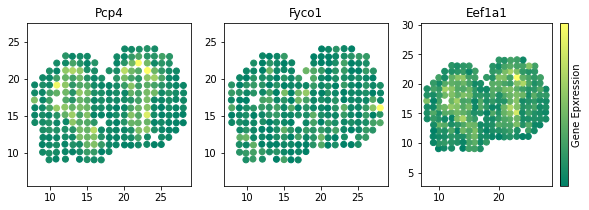

In [27]:
from matplotlib import rcParams
plt.rcParams["figure.figsize"] = [10,3]
m = ['Pcp4', 'Fyco1', 'Eef1a1']
for i, g in enumerate(['Pcp4', 'Fyco1', 'Eef1a1']):
    plt.subplot(1, 3, i + 1)
    plt.scatter(sample_info['x'], sample_info['y'], c=Y.T[g],cmap = 'summer');
    # plt.figure(figsize=(10,3))
    plt.title(m[i])
    plt.axis('equal')


plt.colorbar(ticks=[0,1],label = 'Gene Epxression');

plt.show()
